# Use A CNN To Process The Image

# Requirements 

### Datasets:
Kaggle Data Set:

### Python:
Python3 (3.9.18)

### Modules:
TensorFlow (2.14.0)

Numpy (1.24.3)



Goal: Build a CNN to Determine Predict Malignancy Of Breast Tissues From Patient Slides 

## Part 1 - Importing the libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from platform import python_version
print('Python:',  python_version())
print ("Tensor Flow:", tf.__version__)

Python: 3.11.5
Tensor Flow: 2.14.0


## Part 2 - Loading The Dataset

In [3]:
dataset_path = 'P:/Portfolio Sets/CNN Breast Tumors/BreaKHis 400X/train' 
#watch the direction of slashes, '\' will confuse python use '/' or '\\'

### Training Set

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path, #file path
    labels = 'inferred',  #Automatically infer labels from directory structure (folder names)
    label_mode = 'categorical',  #Categorical/int/etc.
    color_mode='rgb', #Sets the color of the images rgb/grayscale
    image_size = (64, 64), #Image size for resizing
    batch_size = 32,  #Batch size(number of images per batch)
    shuffle = True, #Shuffles the images prior to selection for batch designation (True - default) 
    # False enables consistency for verifying image augmentation, but should be True when deploying
    seed = 100, #Same random selection instance each time, required for splitting into training and validation sets
    validation_split = 0.2,  #Dataset Split for training and validation sets
    subset = 'training')  #Specify training/validation set

Found 1148 files belonging to 2 classes.
Using 919 files for training.


### Validation Set

In [5]:
# Load the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path, 
    labels = 'inferred',
    label_mode ='categorical',
    color_mode='rgb',
    image_size = (64, 64),
    batch_size = 32,
    seed = 100,
    validation_split = 0.2,
    subset = 'validation')

Found 1148 files belonging to 2 classes.
Using 229 files for validation.


### Test Set

In [6]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'P:/Portfolio Sets/CNN Breast Tumors/BreaKHis 400X/test', #file path
    labels = 'inferred',  #Automatically infer labels from directory structure (folder names)
    label_mode = 'categorical',  #Categorical/int/etc.
    color_mode='rgb', #Sets the color of the images rgb/grayscale
    image_size = (64, 64), #Image size for resizing
    batch_size = 9,  #Number must be included if the CNN model has a batch size shapes need to match (Batch, height, width, rgb)
    shuffle = False,
    validation_split = None,  #Dataset Split for training and validation sets
    subset = None)  #Specify training/validation set

Found 547 files belonging to 2 classes.


### TensorFlow Datatype
TensorFlow Data is a tuple of tuple datatype

It consists of TensorSpec which will contain either image or label information. This example contains:

1) Image data (BatchSize, Height, Width, RGB/BW) 
    
    a) BatchSize = Number of data instance per Tensor
    
    b) Height = Pixel Height
    
    c) Width = Pixel Width
    
    d) RGB/BW = Color Channels (RGB = 3, BW = 1)
    
Notes: Iterating through the image data will give call height, row, color channels as a multidimensional array. 

Example: (5, 4, 3) image formats to 5 columns(height) with 4 rows(width) but at each position 3 colum values for each RGB channel . 

2) Label Data (BatchSize, ClassLabels) 
    
    a) BatchSize = Number of data instance per Tensor
    
    b) ClassLabels = Number of classes set ("inferred" or specified upon loading data)

In [7]:
print(train_dataset.element_spec)
print("+++++++++++++++++++++++++++++")
print(train_dataset.class_names)

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))
+++++++++++++++++++++++++++++
['benign', 'malignant']


### Iterating with Tensorflow Data

During an interative process (For loop/ While), you must be aware of key processes/best practices

1) If shuffle = true during data loading, recalling an iterative function of the dataset will reshuffle the data each time unless you reload the data fresh.    

2) No Batch Index is stored in the TF data. A batch index is useful for perform operations on a specific batch. To generate a makeshift one use Python's enumerate function.

3) Ensure to call all tensorspecs of the TF data in the function to avoid confusion

##### Examples of Proper Iterative Function:

1) for images, labels in TF_dataset:

2) for i, (images, labels) in enumerate(TD_dataset): 

Here, Enumerate returns a tuple containing (batch count, value = (images, labels))  

### (Optional) Image Verification
Image Verification with TensorFlow datasets, requires iteration functions (see above for proper use)

Ensure shuffle = false to be able to verify datasets. 

Note: Training/Validation datasets should be swapped back to shuffle = True prior to model training 

## Part 2 - Preprocessing/Augmentation 

### Augmentation

Augmentation avoids overfitting the training data during model training. These include geometric transformations, rotate images, zoom in/out, flip images, etc. 

Augmentation can be applied to the training dataset at 1 of 2 different points

Option 1) The Preprocessing Step prior to CNN model (Easier Modularity and Maintenance) (Done Here)

Option 2) Included in the actual CNN model (Easier Deployment)

In [8]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation

Augmentation = tf.keras.models.Sequential([   
    Rescaling(1.0 / 255), #Rescales the pixel values so that all numbers are between 0 and 1
    RandomFlip("horizontal"), #Randomly Flips image
    RandomRotation(factor=0.2) #Rotates Images
])

train_dataset = train_dataset.map(lambda x, y: (Augmentation(x, training = True), y))
# (x, y) = (images, image labels), training = flag to indicate augmentation should be applied during training
# lambda as always is an anonymous function

### Verifying Image Augmentation
NOTE: To verify Image Augmentation is faithful, the training set:

##### shuffle = false 

when initial loading of dataset. Otherwise, images will be reshuffled and you will get a different image output when running the verification; this is an inherent property of tensorflow.

Once verification is confirmed reload the training set with:

##### shuffle = true

### Rescaling Validation and Test DataSet
Validation and Test Datasets should be rescaled to match Training Dataset for model fidelity.

In [9]:
Rescale = tf.keras.Sequential([Rescaling(1.0 / 255)])
validation_dataset = validation_dataset.map(lambda x, y: (Rescale(x, training = False), y))
test_dataset = test_dataset.map(lambda x, y: (Rescale(x, training = False), y))

## Part 3 - Building the CNN

### Initializing the CNN

In [10]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution Layer

In [11]:
# First Layer
cnn.add(tf.keras.layers.Conv2D( #add function applies new layer
    filters = 32, # Number of features
    kernel_size = 3, # Dimensions of feature detector (single digit is squared (X -> 3 x 3) or paired acceptable (X, Y -> (X x Y)  
    activation = 'relu', # Activation type 
    input_shape = (64, 64, 3))) # Tuple that selects image properties (batch size(optional), size, size, 3(RGB) or 1(B&W))

### Step 2 - Pooling 

In [12]:
cnn.add(tf.keras.layers.MaxPool2D(
    pool_size = 2, # frame size of the pool (single digit is squared (X -> 3 x 3) or paired acceptable (X, Y -> (X x Y)  
    strides = 2, # pixels the frame will move over when pooling (single digit is squared (X -> 3 x 3) or paired acceptable (X, Y -> (X x Y)
    padding = 'valid'))

### (Optional) Adding a second convolutional layer

### Step 3 - Flattening

In [13]:
# Flattening - Converts the data into 1D array
cnn.add(tf.keras.layers.Flatten())
#automatically flattens prior to CNN

### Step 4 - Full Connection

In [14]:
# Connect the Layers
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
# units = the number of neurons for this layer (higher usually means more accuracy)

### Step 5 - Output Layer

In [15]:
# Output Layer - Final Layer To Predict Classification
cnn.add(tf.keras.layers.Dense(units = 2, activation='softmax'))
# set the number of neurons for final classification output, binary (units = 1) vs for multiclass/categorical (units = number of categories)
#activation will be sigmoid for binary (units = 1), for multiclass(categorical) could softmax

### Step 6 - Compile The CNN

In [16]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#compiles the cnn to the optimizer and loss function using accuracy as the metric

#Generate the model summary
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 128)               3936384   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 3937538 (15.02 MB)
Trainable params: 3937538 (15.02 MB)
Non-trainable params: 0 (0.00 Byte)
______________

## Part 4 - Training the CNN

### Training Model on Training Set and Evaluating on the Validation Set

In [17]:
cnn.fit(x = train_dataset, validation_data = validation_dataset, epochs = 20)
#trains the cnn

#loss and accuracy = training data
#val_loss and val_accuracy = validation data
#lower loss is better

Epoch 1/20
29/29 [==============================] - 6s 152ms/step - loss: 0.9969 - accuracy: 0.6376 - val_loss: 0.4762 - val_accuracy: 0.8690
Epoch 2/20
29/29 [==============================] - 5s 146ms/step - loss: 0.4906 - accuracy: 0.7998 - val_loss: 0.4582 - val_accuracy: 0.7817
Epoch 3/20
29/29 [==============================] - 5s 147ms/step - loss: 0.4717 - accuracy: 0.8085 - val_loss: 0.3757 - val_accuracy: 0.8996
Epoch 4/20
29/29 [==============================] - 5s 148ms/step - loss: 0.4491 - accuracy: 0.8248 - val_loss: 0.3902 - val_accuracy: 0.8472
Epoch 5/20
29/29 [==============================] - 5s 147ms/step - loss: 0.4856 - accuracy: 0.7845 - val_loss: 0.3642 - val_accuracy: 0.8908
Epoch 6/20
29/29 [==============================] - 5s 148ms/step - loss: 0.4495 - accuracy: 0.8205 - val_loss: 0.3558 - val_accuracy: 0.8908
Epoch 7/20
29/29 [==============================] - 5s 150ms/step - loss: 0.4289 - accuracy: 0.8466 - val_loss: 0.3484 - val_accuracy: 0.8908
Epoch 

## Part 5 - Evaluating The Model

In [18]:
PredictProb = cnn.predict(test_dataset)
print(PredictProb) #Provides an array where the numbers indicate the probability of it being that particular class

61/61 [==============================] - 1s 21ms/step
[[0.9252577  0.07474232]
 [0.89028    0.10972004]
 [0.828322   0.17167804]
 ...
 [0.2600001  0.7399999 ]
 [0.3252921  0.6747079 ]
 [0.11689688 0.88310313]]


In [19]:
PredictClass = (PredictProb >= 0.5).astype(int) #set the threshold as 0.5
PredictClass[0:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [20]:
for i in range(5):
    if PredictClass[i][0] == 1: #result 1st slot as batch dimension so we run result[0] to enter the batch the next [0] selects the element in the batch(the single dog image) 
        prediction = 'benign'
    elif PredictClass[i][1] == 1:    
        prediction = 'malignant'
    else:
        prediction = 'Error'
    print(prediction)

benign
benign
benign
benign
benign


### Confusion Matrix and Accuracy Score
Confusion Matrix can be run on Numpy Arrays and should be one hot encoded prior to running

In [21]:
#Convert the Tensorflow Test Dataset classlabels into a Numpy Array 
TrueClass = np.empty((0, 2)) # Initialize an empty NumPy array with no rows and 2 columns (no data entry yet)
print (TrueClass)
print ('Shape =', TrueClass.shape)
for images, labels in test_dataset:
    nlab = labels.numpy().astype(int)  # Convert labels to a NumPy array ain an integer format
    TrueClass = np.concatenate((TrueClass, nlab), axis=0) #concatenates all the batches joining batches based on columns

print ('+++++++++++++++++++++++++++++++++++++++++++++')
print (TrueClass)
print ('Shape = ', TrueClass.shape)

[]
Shape = (0, 2)
+++++++++++++++++++++++++++++++++++++++++++++
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Shape =  (547, 2)


In [22]:
#Run the confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score

cm_True = np.argmax(TrueClass, axis= 1)  
cm_Predict = np.argmax(PredictClass, axis = 1) #returns index value
#axis = 0 returns the row index that has the highest value in a column), axis = 1 returns the col index for the highest value in a row 


print(confusion_matrix(cm_True, cm_Predict))
print(accuracy_score(cm_True, cm_Predict))

[[120  56]
 [ 45 326]]
0.8153564899451554


### Single Image Prediction

1/1 [==============================] - 0s 78ms/step
[[0.32623872 0.67376125]]
Malignant


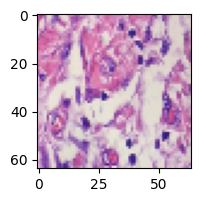

In [23]:
#test a single image from user selection
test_image = tf.keras.utils.load_img('P:/Portfolio Sets/CNN Breast Tumors/BreaKHis 400X/test/malignant/SOB_M_DC-14-10926-400-005.png', target_size = (64, 64))
test_image = tf.keras.utils.img_to_array(test_image) #changes to an array so the cnn model can analyze
test_image /= 255
plt.figure(figsize = (2, 2))
plt.imshow(test_image)
test_image = np.expand_dims(test_image, axis = 0) #adds an extra dimension to match the batch dimension within the CNN model
#dimension of batch is added as the 1st dimension 


result = cnn.predict(test_image)
print (result)

#Class label based on the train_dataset.class_names [benign, malignant]
result = (result >= 0.5).astype(int)
if np.all(result == np.array([1, 0])):
    print('Benign')
elif np.all(result == np.array([0, 1])):
    print('Malignant')
else:
    print('Error')